In [9]:
# Compare the skill of the model forecast using the depth data at the resolution of the DEM.

# Library imports.
import matplotlib.pyplot as plt
import numpy as np
import os

# Local imports.
from rasopt.Utilities import utils, land_cover_utils

In [11]:
# Plan files to compare.
gt_plan_fp = r"C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf"
sim_best_plan_fp = r"C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_Best.hdf"
sim_best_plan_fp = r"C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf";

# Path to the DEM file.
dem_fname = r"DTM_1m.tif"
dem_fp = os.path.join(os.path.dirname(gt_plan_fp), dem_fname)

# Comparison timestep.
timestep = 120
dt = 0.25 # Hours.

# Downsample factor.
resample = 0.05

# HDF paths.
# Cell coordinate path.
cell_coord_path = 'Geometry/2D Flow Areas/Secchia_Panaro/Cells Center Coordinate'

# Water depths path.
depth_path = ('Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/'
              '2D Flow Areas/Secchia_Panaro/Depth')

# Manning's n calibration table path.
cal_table_path = "Geometry/Land Cover (Manning's n)/Calibration Table"

# Cell facepoint index path.
cell_facepoint_idx_path = 'Geometry/2D Flow Areas/Secchia_Panaro/Cells FacePoint Indexes'

# Facepoint coordinate path.
facepoint_coord_path = 'Geometry/2D Flow Areas/Secchia_Panaro/FacePoints Coordinate'

In [12]:
# Depth rasters at the resolution of the DEM raster.
gt_depths, gt_depth_path = land_cover_utils.terrain_water_depth(dem_fp, gt_plan_fp, cell_facepoint_idx_path, facepoint_coord_path,
                                        depth_path, cell_coord_path, timestep, out_fname_prefix='GT', nodata=-999.0, 
                                        cleanup_rasters=False, resample=resample)
sim_depths, sim_depth_path = land_cover_utils.terrain_water_depth(dem_fp, sim_best_plan_fp, cell_facepoint_idx_path, facepoint_coord_path,
                                        depth_path, cell_coord_path, timestep, out_fname_prefix='', nodata=-999.0,
                                        cleanup_rasters=False, resample=resample)


# Compute the sensitivity.
sensitivity = utils.inun_sensitivity(gt_depths, sim_depths, depth_cut=0.01)

# Type I and II Error.
typeI = utils.inun_error(gt_depths, sim_depths, 1, depth_cut=0.01)
typeII = utils.inun_error(gt_depths, sim_depths, 2, depth_cut=0.01)

# Print results.
print('Sensitivity', sensitivity)
print('Type I', typeI)
print('Type II', typeII)

C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_120.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\G

In [13]:
# Get the total number of timesteps. 
depths = utils.extract_depths(gt_plan_fp, depth_path, cell_coord_path)
Nt = depths.shape[1] - 2
print(Nt)

566


In [14]:
# Critical depth comparison.
depth_cut = 0.1

# Time to critical depth arrays.
gt_tc = np.zeros_like(gt_depths)
sim_tc = np.zeros_like(gt_depths)

timesteps = list(range(Nt))
for t in range(0,Nt,2):
    print('Processing Timestep:', t)
    timestep = t
    # Get the depths for that timestep.
    gt_depths, gt_depth_path = land_cover_utils.terrain_water_depth(dem_fp, gt_plan_fp, cell_facepoint_idx_path, facepoint_coord_path,
                                        depth_path, cell_coord_path, timestep, out_fname_prefix='GT', nodata=-999.0, cleanup_rasters=True,
                                                                   resample=resample)
    sim_depths, sim_depth_path = land_cover_utils.terrain_water_depth(dem_fp, sim_best_plan_fp, cell_facepoint_idx_path, facepoint_coord_path,
                                            depth_path, cell_coord_path, timestep, out_fname_prefix='', nodata=-999.0, cleanup_rasters=True,
                                                                     resample=resample)
    # Cells that exceed cutoff depth.
    gt_exceed = gt_depths > depth_cut
    sim_exceed = sim_depths > depth_cut
    
    # Set gt_tc or sim_tc cells to the timestep when the first surpass the depth cut.
    gt_tc_mask = gt_tc > 0 # Already assigned cells.
    sim_tc_mask = sim_tc > 0 # Already assigned cells.
    gt_tc[gt_exceed & ~gt_tc_mask] = t
    sim_tc[sim_exceed & ~sim_tc_mask] = t
    
    print('Completed Timstep:', t, '\n')

Processing Timestep: 0
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_0.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\s

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_14.tif
(1335, 1521)
Completed Timstep: 14 

Processing Timestep: 16
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_16.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Mater

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_30.tif
(1335, 1521)
Completed Timstep: 30 

Processing Timestep: 32
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.ge

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_46.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_46.tif
(1335, 1521)
Completed Timstep: 46 

Processing Timestep: 48
C:\Users\ay434\Box\Research\F

(1335, 1521)
Completed Timstep: 60 

Processing Timestep: 62
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_62.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.ge

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_76.tif
(1335, 1521)
Completed Timstep: 76 

Processing Timestep: 78
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_78.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Mater

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_92.tif
(1335, 1521)
Completed Timstep: 92 

Processing Timestep: 94
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.ge

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_108.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_108.tif
(1335, 1521)
Completed Timstep: 108 

Processing Timestep: 110
C:\Users\ay434\Box\Resear

(1335, 1521)
Completed Timstep: 122 

Processing Timestep: 124
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_124.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_138.tif
(1335, 1521)
Completed Timstep: 138 

Processing Timestep: 140
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_154.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_154.tif
(1335, 1521)
Completed Timstep: 154 

Processing Timestep: 156
C:\Users\ay434\Box\Resear

(1335, 1521)
Completed Timstep: 168 

Processing Timestep: 170
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_170.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_184.tif
(1335, 1521)
Completed Timstep: 184 

Processing Timestep: 186
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_200.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_200.tif
(1335, 1521)
Completed Timstep: 200 

Processing Timestep: 202
C:\Users\ay434\Box\Resear

(1335, 1521)
Completed Timstep: 214 

Processing Timestep: 216
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_216.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_230.tif
(1335, 1521)
Completed Timstep: 230 

Processing Timestep: 232
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_246.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_246.tif
(1335, 1521)
Completed Timstep: 246 

Processing Timestep: 248
C:\Users\ay434\Box\Resear

(1335, 1521)
Completed Timstep: 260 

Processing Timestep: 262
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_262.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_276.tif
(1335, 1521)
Completed Timstep: 276 

Processing Timestep: 278
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_292.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_292.tif
(1335, 1521)
Completed Timstep: 292 

Processing Timestep: 294
C:\Users\ay434\Box\Resear

(1335, 1521)
Completed Timstep: 306 

Processing Timestep: 308
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_308.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_322.tif
(1335, 1521)
Completed Timstep: 322 

Processing Timestep: 324
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_338.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_338.tif
(1335, 1521)
Completed Timstep: 338 

Processing Timestep: 340
C:\Users\ay434\Box\Resear

(1335, 1521)
Completed Timstep: 352 

Processing Timestep: 354
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_354.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_368.tif
(1335, 1521)
Completed Timstep: 368 

Processing Timestep: 370
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_384.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_384.tif
(1335, 1521)
Completed Timstep: 384 

Processing Timestep: 386
C:\Users\ay434\Box\Resear

(1335, 1521)
Completed Timstep: 398 

Processing Timestep: 400
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_400.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_414.tif
(1335, 1521)
Completed Timstep: 414 

Processing Timestep: 416
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_430.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_430.tif
(1335, 1521)
Completed Timstep: 430 

Processing Timestep: 432
C:\Users\ay434\Box\Resear

(1335, 1521)
Completed Timstep: 444 

Processing Timestep: 446
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_446.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_460.tif
(1335, 1521)
Completed Timstep: 460 

Processing Timestep: 462
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_476.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_476.tif
(1335, 1521)
Completed Timstep: 476 

Processing Timestep: 478
C:\Users\ay434\Box\Resear

(1335, 1521)
Completed Timstep: 490 

Processing Timestep: 492
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_492.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_506.tif
(1335, 1521)
Completed Timstep: 506 

Processing Timestep: 508
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_522.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_522.tif
(1335, 1521)
Completed Timstep: 522 

Processing Timestep: 524
C:\Users\ay434\Box\Resear

(1335, 1521)
Completed Timstep: 536 

Processing Timestep: 538
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_538.tif
(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

(1335, 1521)
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_15min_campagna0.05.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson.geojson C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_raster_552.tif
(1335, 1521)
Completed Timstep: 552 

Processing Timestep: 554
C:\Users\ay434\Box\Research\Flood_Sim_Materials\Presentations\EFMH_Presentation_20220316\Secchia_Panaro.p23_Orig.hdf
DEM SHAPE (1335, 1521)
gdal_rasterize -at -l mesh_gjson -a Depth -tr 20.00197238658777 20.014232209737827 -a_nodata -999.0 -te 652093.732276195 4945405.219236948 682516.732276195 4972124.219236948 -ot Float32 -of GTiff C:\Users\ay434\Documents\rasopt\src\rasopt\Utilities\Geo_Files\mesh_gjson

In [15]:
delta_save_fname = 'delta_30min_camp0.05.npy'

125.5
232029.0


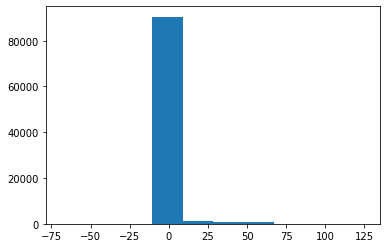

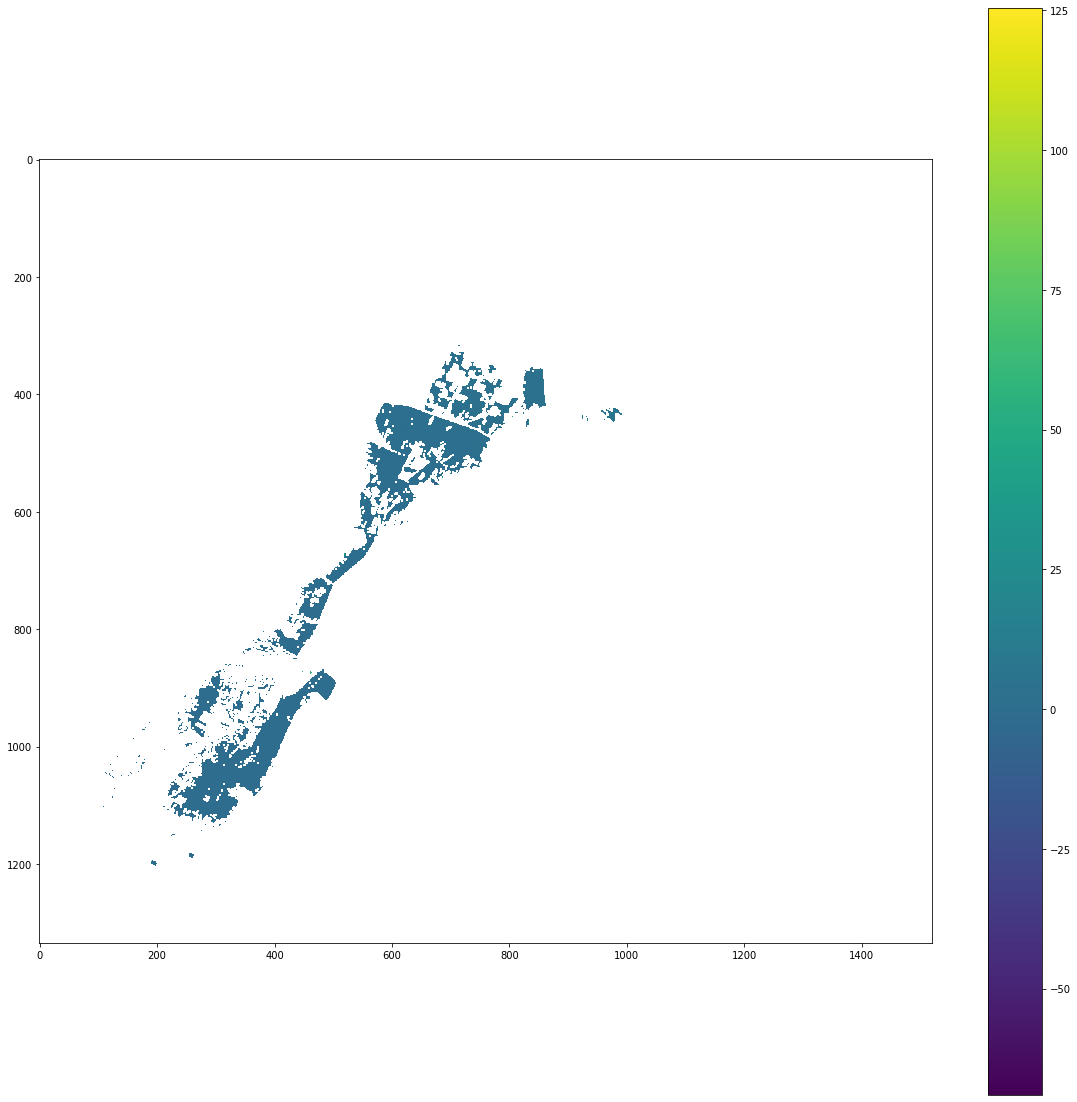

In [16]:
# Difference in time to critical depth.
delta_tc = (gt_tc - sim_tc) * dt
print(np.max(delta_tc[delta_tc > 0]))

print(np.sum(delta_tc))

fig, ax = plt.subplots()
ax.hist(delta_tc[delta_tc != 0])

delta_tc_plot = delta_tc.copy()
delta_tc_plot[delta_tc_plot == 0] = np.nan
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(delta_tc_plot)
plt.colorbar(im)

np.save(delta_save_fname, delta_tc)